# ADAPTIVE DECODING UNDER NOISE DRIFT USING SYNDROME STATISTICS
Flow of the project
1- Circuit for repitition code for gate level and phenomenological 
2- Sampling of the circuit and defect matrix generation
3- Estimating the probabilities
   (a)- Frequency domain
   (b)- Time domain
4- DEM definition
5- Logical error rate 
  (a)- Sliding window decoder for full circuit- relative LER and LER vs PER
  (b)- Decoding without window for full circuit- relative LER and LER vs PER
  (c)- Decoding without window for smaller rounds- relative LER and LER vs PER

# CIRCUIT DEFINTION

In [2]:
#defining the stim circuit for a repitition code

def QRC_Phen_circ_freq(d,QEC_Rounds,p0,p1,N):
   
   import numpy as np
   import stim
   data_qubits = list(range(0,d))
   ancilla_qubits = list(range(d,2*d-1))
    # j ranges from 0 to R-1

   j_values = np.arange(QEC_Rounds-1)          # j = [0, 1, ..., R-1]
   sin_term = np.sin(2 * np.pi * (j_values[:, None] + 1) / N[None, :])
   results = p1 * sin_term
   p = np.sum(results, axis=1) +p0
   
  #  noise_p=[]   this part of the code is commented to assign fix probability to each qubit, laetr we can change this part 
  #  for _ in range(2*d-1):
  #   noise_p.append(p1)#pper bound to depolarizing probabilities random.uniform(0,p1)
   
   circuit = stim.Circuit()
   # once again this part should be uncommented once we decide to take the arbitrary data
  #  for i in range(2*d-1):
  #    circuit.append("DEPOLARIZE1",[i],p1)
   circuit.append("DEPOLARIZE1",data_qubits,p0)
   circuit.append("DEPOLARIZE1",ancilla_qubits,p0)
   for i in range(d-1):
     circuit.append("CNOT",[i,d+i])
     circuit.append("CNOT",[i+1,d+i])
    # circuit.append("DEPOLARIZE2",[i+1,d+i],p0)
   circuit.append("MR",ancilla_qubits)
   for i in range(d-1):
     circuit.append("DETECTOR",[stim.target_rec(-i-1)])  #detector labelling for future reference
   circuit.append("TICK",[])
   repeat = stim.Circuit()
   for j in range(QEC_Rounds-1):
    # once agian this part should be uncommented for taking arbitrary probability 
    #  for i in range(2*d-1):
    #    repeat.append("DEPOLARIZE1",[i],   p1*0.5*math.sin(2*pi*(j+1)/N)+p1)
     repeat.append("DEPOLARIZE1",data_qubits,p[j])
     repeat.append("DEPOLARIZE1",ancilla_qubits,p[j])
     for i in range(d-1):
       repeat.append("CNOT",[i,d+i])
       repeat.append("CNOT",[i+1,d+i])
     repeat.append("MR",ancilla_qubits)
     for i in range(d-1):  
       repeat.append("DETECTOR",[stim.target_rec(-i-d),stim.target_rec(-i-1)])
   circuit += repeat
 # to be interpreted for data qubits measurement 
   circuit.append("M",data_qubits)
   # circuit.append("SHIFT_COORDS",[],(0,2))
   for i in range(d-1):
     circuit.append("DETECTOR",[stim.target_rec(-i-1),stim.target_rec(-i-2),stim.target_rec(-i-d-1)])  #detector labelling and which data is stored, key checks%%
   dat_meas_xor =[]
   for i in range(d):
     dat_meas_xor.append(stim.target_rec(-i-1))

   circuit.append("OBSERVABLE_INCLUDE", dat_meas_xor,0)
   return circuit
def QRC_Phen_circ_freq_gate_level(d,QEC_Rounds,p0,p1,N):
   import numpy as np
   import stim
   data_qubits = list(range(0,d))
   ancilla_qubits = list(range(d,2*d-1))
   

  #  j_values = np.arange(QEC_Rounds-1)          # j = [0, 1, ..., R-1]
  #  sin_term = np.sin(2 * np.pi * (j_values[:, None] + 1) / N[None, :])
  # #  results = p1 * sin_term
  # #  p = np.sum(results, axis=1) +p0
       
  #  j_values = np.arange(QEC_Rounds - 1)  # j = [0, 1, ..., R-2]
  
  # # Reshape j_values for broadcasting (QEC_Rounds-1, 1, 1)
  #  j_values_reshaped = j_values[:, None, None]
  
  # # Calculate sin term with proper broadcasting
  # # N has shape (rows, cols), so we add extra dimensions for broadcasting
  #  sin_term = np.sin(2 * np.pi * (j_values_reshaped + 1) / N[None, :, :])
  
  # # Multiply p1 (shape (rows, cols)) with sin_term (shape (QEC_Rounds-1, rows, cols))
  #  results = p1[None, :,:] * sin_term
  
  # # Sum over the j_values axis (axis=0) and add p0
  #  p = np.sum(results, axis=0) + p0
  #  noise_p=[]   this part of the code is commented to assign fix probability to each qubit, laetr we can change this part 
  #  for _ in range(2*d-1):
  #   noise_p.append(p1)#pper bound to depolarizing probabilities random.uniform(0,p1)
   
    # Ensure inputs are column vectors
   p0 = np.array(p0).reshape(-1, 1)  # shape (3d-2, 1)
   p1 = np.array(p1).reshape(-1, 1)  # shape (3d-2, 1)
   N = np.array(N).reshape(-1, 1)    # shape (3d-2, 1)

   j_values = np.arange(1, QEC_Rounds)  # j = [1, 2, ..., QEC_Rounds-1]

    # Compute sin term: shape (3d-2, QEC_Rounds-1)
   sin_term = np.sin(2 * np.pi * j_values / N)  # Broadcasting over N and j_values

    # Compute p: shape (3d-2, QEC_Rounds-1)
   p = p0 + p1 * sin_term
   circuit = stim.Circuit()
   # once again this part should be uncommented once we decide to take the arbitrary data
   for i in range(2*d-1):
      circuit.append("DEPOLARIZE1",[i],p0[i,0])
   #circuit.append("DEPOLARIZE1",data_qubits,p0)
   #circuit.append("DEPOLARIZE1",ancilla_qubits,p0)
   for i in range(d-1):
     circuit.append("CNOT",[i,d+i])
     circuit.append("DEPOLARIZE2",[i,d+i],p0[2*d-1+i,0])
     circuit.append("CNOT",[i+1,d+i])
     circuit.append("DEPOLARIZE2",[i+1,d+i],p0[2*d-1+i,0])
   circuit.append("MR",ancilla_qubits)
   for i in range(d-1):
     circuit.append("DETECTOR",[stim.target_rec(-i-1)])  #detector labelling for future reference
   circuit.append("TICK",[])
   repeat = stim.Circuit()
   for j in range(QEC_Rounds-1):
    # once agian this part should be uncommented for taking arbitrary probability 
      for i in range(2*d-1):
       repeat.append("DEPOLARIZE1",[i], p[i,j])
       
      for i in range(d-1):
       repeat.append("CNOT",[i,d+i])
       repeat.append("DEPOLARIZE2",[i,d+i],p[2*d-1+i,j])
       repeat.append("CNOT",[i+1,d+i])
       repeat.append("DEPOLARIZE2",[i+1,d+i],p[2*d-1+i,j])
      repeat.append("MR",ancilla_qubits)
      for i in range(d-1):  
       repeat.append("DETECTOR",[stim.target_rec(-i-d),stim.target_rec(-i-1)])
   circuit += repeat
 # to be interpreted for data qubits measurement 
   circuit.append("M",data_qubits)
   # circuit.append("SHIFT_COORDS",[],(0,2))
   for i in range(d-1):
     circuit.append("DETECTOR",[stim.target_rec(-i-1),stim.target_rec(-i-2),stim.target_rec(-i-d-1)])  #detector labelling and which data is stored, key checks%%
   dat_meas_xor =[]
   for i in range(d):
     dat_meas_xor.append(stim.target_rec(-i-1))

   circuit.append("OBSERVABLE_INCLUDE", dat_meas_xor,0)
   return circuit

In [9]:
# defining the stim circuit explicitly for ler calculations for repetition code
def QRC_Phen_circ_freq_ler(d,QEC_Rounds,p0,p1,N,start_j,end_j):
   
   import numpy as np
   import stim
   data_qubits = list(range(0,d))
   ancilla_qubits = list(range(d,2*d-1))
    # j ranges from 0 to R-1

   j_values = np.arange(start_j,end_j,1)        # j = [0, 1, ..., R-1]
   sin_term = np.sin(2 * np.pi * (j_values[:, None] + 1) / N[None, :])
   results = p1 * sin_term
   p = np.sum(results, axis=1) +p0
   
  #  noise_p=[]   this part of the code is commented to assign fix probability to each qubit, laetr we can change this part 
  #  for _ in range(2*d-1):
  #   noise_p.append(p1)#pper bound to depolarizing probabilities random.uniform(0,p1)
   
   circuit = stim.Circuit()
   # once again this part should be uncommented once we decide to take the arbitrary data
  #  for i in range(2*d-1):
  #    circuit.append("DEPOLARIZE1",[i],p1)
   circuit.append("DEPOLARIZE1",data_qubits,p[0])
   circuit.append("DEPOLARIZE1",ancilla_qubits,p[0])
   for i in range(d-1):
     circuit.append("CNOT",[i,d+i])
     circuit.append("CNOT",[i+1,d+i])
    # circuit.append("DEPOLARIZE2",[i+1,d+i],p0)
   circuit.append("MR",ancilla_qubits)
   for i in range(d-1):
     circuit.append("DETECTOR",[stim.target_rec(-i-1)])  #detector labelling for future reference
   circuit.append("TICK",[])
   repeat = stim.Circuit()
   for j in range(start_j+1,end_j,1):
    # once agian this part should be uncommented for taking arbitrary probability 
    #  for i in range(2*d-1):
    #    repeat.append("DEPOLARIZE1",[i],   p1*0.5*math.sin(2*pi*(j+1)/N)+p1)
     repeat.append("DEPOLARIZE1",data_qubits,p[j-start_j])
     repeat.append("DEPOLARIZE1",ancilla_qubits,p[j-start_j])
     for i in range(d-1):
       repeat.append("CNOT",[i,d+i])
       repeat.append("CNOT",[i+1,d+i])
     repeat.append("MR",ancilla_qubits)
     for i in range(d-1):  
       repeat.append("DETECTOR",[stim.target_rec(-i-d),stim.target_rec(-i-1)])
   circuit += repeat
 # to be interpreted for data qubits measurement 
   circuit.append("M",data_qubits)
   # circuit.append("SHIFT_COORDS",[],(0,2))
   for i in range(d-1):
     circuit.append("DETECTOR",[stim.target_rec(-i-1),stim.target_rec(-i-2),stim.target_rec(-i-d-1)])  #detector labelling and which data is stored, key checks%%
   dat_meas_xor =[]
   for i in range(d):
     dat_meas_xor.append(stim.target_rec(-i-1))

   circuit.append("OBSERVABLE_INCLUDE", dat_meas_xor,0)
   return circuit

In [10]:
def QRC_Phen_circ_freq_gate_level_ler(d,QEC_Rounds,p0,p1,N,start_j,end_j):
   import numpy as np
   import stim
   data_qubits = list(range(0,d))
   ancilla_qubits = list(range(d,2*d-1))
   

  #  j_values = np.arange(QEC_Rounds-1)          # j = [0, 1, ..., R-1]
  #  sin_term = np.sin(2 * np.pi * (j_values[:, None] + 1) / N[None, :])
  # #  results = p1 * sin_term
  # #  p = np.sum(results, axis=1) +p0
       
  #  j_values = np.arange(QEC_Rounds - 1)  # j = [0, 1, ..., R-2]
  
  # # Reshape j_values for broadcasting (QEC_Rounds-1, 1, 1)
  #  j_values_reshaped = j_values[:, None, None]
  
  # # Calculate sin term with proper broadcasting
  # # N has shape (rows, cols), so we add extra dimensions for broadcasting
  #  sin_term = np.sin(2 * np.pi * (j_values_reshaped + 1) / N[None, :, :])
  
  # # Multiply p1 (shape (rows, cols)) with sin_term (shape (QEC_Rounds-1, rows, cols))
  #  results = p1[None, :,:] * sin_term
  
  # # Sum over the j_values axis (axis=0) and add p0
  #  p = np.sum(results, axis=0) + p0
  #  noise_p=[]   this part of the code is commented to assign fix probability to each qubit, laetr we can change this part 
  #  for _ in range(2*d-1):
  #   noise_p.append(p1)#pper bound to depolarizing probabilities random.uniform(0,p1)
   
    # Ensure inputs are column vectors
   p0 = np.array(p0).reshape(-1, 1)  # shape (3d-2, 1)
   p1 = np.array(p1).reshape(-1, 1)  # shape (3d-2, 1)
   N = np.array(N).reshape(-1, 1)    # shape (3d-2, 1)

   j_values = np.arange(start_j,end_j,1)  # j = [1, 2, ..., QEC_Rounds-1]

    # Compute sin term: shape (3d-2, QEC_Rounds-1)
   sin_term = np.sin(2 * np.pi * (j_values +1)/ N)  # Broadcasting over N and j_values

    # Compute p: shape (3d-2, QEC_Rounds-1)
   p = p0 + p1 * sin_term
   circuit = stim.Circuit()
   # once again this part should be uncommented once we decide to take the arbitrary data
   for i in range(2*d-1):
      circuit.append("DEPOLARIZE1",[i],p0[i,0])
   #circuit.append("DEPOLARIZE1",data_qubits,p0)
   #circuit.append("DEPOLARIZE1",ancilla_qubits,p0)
   for i in range(d-1):
     circuit.append("CNOT",[i,d+i])
     circuit.append("DEPOLARIZE2",[i,d+i],p0[2*d-1+i,0])
     circuit.append("CNOT",[i+1,d+i])
     circuit.append("DEPOLARIZE2",[i+1,d+i],p0[2*d-1+i,0])
   circuit.append("MR",ancilla_qubits)
   for i in range(d-1):
     circuit.append("DETECTOR",[stim.target_rec(-i-1)])  #detector labelling for future reference
   circuit.append("TICK",[])
   repeat = stim.Circuit()
   for j in range(start_j+1,end_j,1):
    # once agian this part should be uncommented for taking arbitrary probability 
      for i in range(2*d-1):
       repeat.append("DEPOLARIZE1",[i], p[i,j-start_j])
       
      for i in range(d-1):
       repeat.append("CNOT",[i,d+i])
       repeat.append("DEPOLARIZE2",[i,d+i],p[2*d-1+i,j-start_j])
       repeat.append("CNOT",[i+1,d+i])
       repeat.append("DEPOLARIZE2",[i+1,d+i],p[2*d-1+i,j-start_j])
      repeat.append("MR",ancilla_qubits)
      for i in range(d-1):  
       repeat.append("DETECTOR",[stim.target_rec(-i-d),stim.target_rec(-i-1)])
   circuit += repeat
 # to be interpreted for data qubits measurement 
   circuit.append("M",data_qubits)
   # circuit.append("SHIFT_COORDS",[],(0,2))
   for i in range(d-1):
     circuit.append("DETECTOR",[stim.target_rec(-i-1),stim.target_rec(-i-2),stim.target_rec(-i-d-1)])  #detector labelling and which data is stored, key checks%%
   dat_meas_xor =[]
   for i in range(d):
     dat_meas_xor.append(stim.target_rec(-i-1))

   circuit.append("OBSERVABLE_INCLUDE", dat_meas_xor,0)
   return circuit

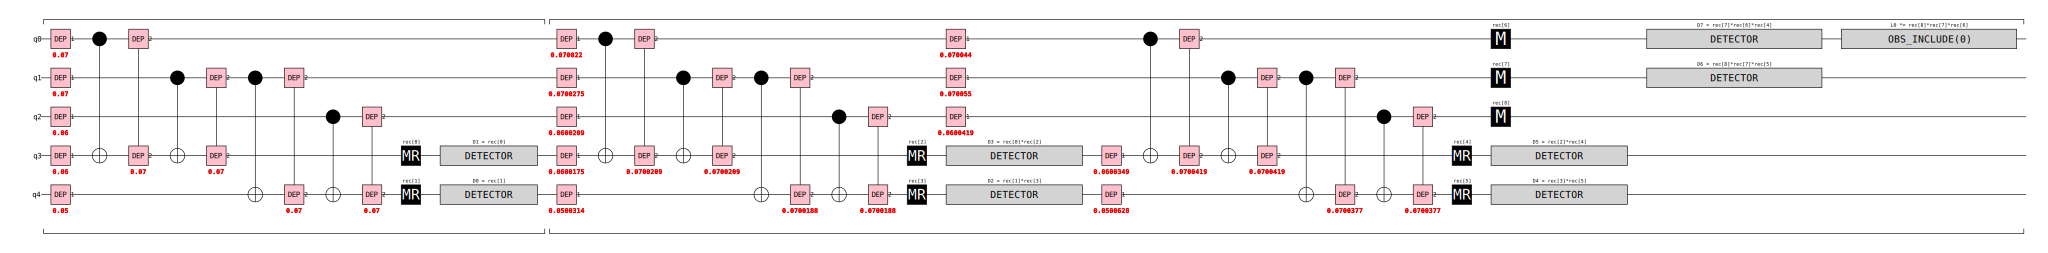

In [4]:
d = 3
QEC_Rounds = 3
number_shots = 1
W = 1000  
W1_s, W2_s, W3_s = 500, 500, 500
num_trials = 10  # Number of trials for error bars
import numpy as np
# Probabilities and counts
p0 = np.array([0.07, 0.07, 0.06, 0.06, 0.05, 0.07, 0.07])
p1 = np.array([0.035, 0.035, 0.03, 0.025, 0.03, 0.03, 0.03])
N = np.array([10000, 8000, 9000, 9000, 6000, 9000, 10000])
QRC_Phen_circ_freq_gate_level(d,QEC_Rounds,p0,p1,N).diagram("timeline-svg")

# CIRCUIT SAMPLING

In [11]:
def Samples_RC(rc_circuit,number_shots):
  sampler = rc_circuit.compile_sampler()
  Samples =sampler.sample(shots= number_shots)
  return Samples
def detector_samples(circuit_decode,num_shots):
    sampler = circuit_decode.compile_detector_sampler()
    detection_events,obs_flips = sampler.sample(shots=num_shots,separate_observables=True)
    return detection_events,obs_flips
def defect_matrix(d,QEC_Rounds,number_shots,samples):
  #  samples = Samples_RC(rc_circuit,number_shots)
    num_shots = number_shots
    num_rounds = QEC_Rounds 
    anc_qubit_samples  = samples[:,:(d-1)*num_rounds]
    data_qubit_samples = samples[:,(d-1)*num_rounds:]
    anc_qubit_samples  = anc_qubit_samples.reshape(num_shots,num_rounds,d-1)
    import numpy as np
    syndrome_proj = np.zeros(shape=(num_shots,d-1), dtype=bool)
    for i in range(d-1):
        syndrome_proj[:,i] = (data_qubit_samples[:,i])^(data_qubit_samples[:,i+1])  # ^(anc_qubit_samples[:,num_rounds-1,i])
    
    import numpy as np
    syndrome_proj = np.array(syndrome_proj)
    syndrome_proj = syndrome_proj.reshape(num_shots,1,d-1)
    import numpy as np
    temp_round = np.arange(1)
    shots= np.arange(num_shots)
    rounds = np.arange(num_rounds)
    
    import xarray as xr
  #  data_qubits = list(range(0,d))
    ancilla_qubits = list(range(d,2*d-1))
    anc_meas = xr.DataArray(data = anc_qubit_samples, dims = ["shot","qec_round","anc_qubit"], coords = dict(shot=shots,qec_round= rounds,anc_qubit = ancilla_qubits))
  #  data_meas = xr.DataArray(data   = data_qubit_samples, dims   = ["shot","data_qubits"], coords = dict(shot=shots,data_qubits= data_qubits))
    syndrome_proj = xr.DataArray(data = syndrome_proj, dims = ["shot","qec_round","anc_qubit"],coords = dict(shot=shots,qec_round= temp_round,anc_qubit = ancilla_qubits))
    initial_state = np.zeros(shape=(num_shots,1), dtype=bool)

    syndromes_Z = xr.concat([anc_meas,syndrome_proj], dim="qec_round")
    syndrome_matrix_copy = syndromes_Z.copy()
    syndrome_matrix_copy.data[:,-1,:] = initial_state
    defects_matrix_Z = syndromes_Z ^ syndrome_matrix_copy.roll(qec_round=1)
    return defects_matrix_Z

# SLIDING WINDOW ESTIMATING FUNCTIONS

In [12]:
def est_prob_freq_corrected(d, QEC_Rounds, number_shots, defect_matrix, W, N, p1,p0):
    num_rounds = QEC_Rounds
    import numpy as np
    # Initialize arrays
    p_r = np.zeros((d-1, num_rounds))
    p_c = np.zeros((d-2, num_rounds+1))
    v_r = np.zeros((d-1, num_rounds))
    v_c = np.zeros((d-2, num_rounds+1))
    v_0 = np.zeros((d-1, num_rounds+1))
    
    # Vectorized computation for v_0, v_r, v_c using cumulative sums
    for i in range(d-1):
        # Cumulative sum for v_0
        a = np.array(defect_matrix[0, :, i])
        cum_a = np.concatenate([[0], np.cumsum(a)])
        v_0[i, W:num_rounds+1] = cum_a[W:num_rounds+1] - cum_a[:num_rounds-W+1]
        #v_0[i, W:num_rounds]= cum_a[W:num_rounds] - cum_a[:num_rounds-W]
        # Cumulative sum for v_r (only for rounds W to num_rounds-1)
        if i < d-1:  # All rows
            
            b = a[0:num_rounds-1] * a[1:num_rounds]  # Product of consecutive timesteps
            cum_b = np.concatenate([[0], np.cumsum(b)])
            #v_r[i, W:num_rounds] = cum_b[W-1:num_rounds-1] - cum_b[:num_rounds-W]
            v_r[i, W:num_rounds] = cum_b[W:num_rounds] - cum_b[:num_rounds-W]
    for i in range(d-2):
        # Cumulative sum for v_c
        a_i = np.array(defect_matrix[0, :, i])
        a_i1 = np.array(defect_matrix[0, :, i+1])
        c = a_i* a_i1  # Product with adjacent qubit
        cum_c = np.concatenate([[0], np.cumsum(c)])
        v_c[i, W:num_rounds+1] = cum_c[W:num_rounds+1] - cum_c[:num_rounds+1-W]
    
    # Normalize
    v_0 /= W
    v_r /= W
    v_c /= W
    
    # Initialize boundary probabilities
    p_b = np.zeros((2, num_rounds+1))
    j_vals = np.arange(W)         # j = [0, 1, ..., R-1]
    sin_term = np.sin(2 * np.pi * (j_vals[:, None] ) / N[None, :])
    results = p1 * sin_term
    p_val = np.sum(results, axis=1) +p0
    p_r[:, j_vals] = p_val
    p_c[:, j_vals] = p_val
    p_b[:, j_vals] = p_val
    
    # Vectorized computation for p_r and p_c (j >= W)
    j_vals_r = np.arange(W, num_rounds)
    if j_vals_r.size > 0:
        num_r = v_r[:, j_vals_r] - v_0[:, j_vals_r] * v_0[:, j_vals_r+1]
        den_r = 1 - 2*(v_0[:, j_vals_r] + v_0[:, j_vals_r+1]) + 4*v_r[:, j_vals_r]
        p_r[:, j_vals_r] = 0.5 - np.sqrt(np.maximum(0.25 - num_r / den_r, 0))
    
    j_vals_c = np.arange(W, num_rounds+1)
    if j_vals_c.size > 0:
        num_c = v_c[:, j_vals_c] - v_0[:d-2, j_vals_c] * v_0[1:d-1, j_vals_c]
        den_c = 1 - 2*(v_0[:d-2, j_vals_c] + v_0[1:d-1, j_vals_c]) + 4*v_c[:, j_vals_c]
        p_c[:, j_vals_c] = 0.5 - np.sqrt(np.maximum(0.25 - num_c / den_c, 0))
    
    # Compute boundary probabilities p_b
    j_src = np.arange(W, num_rounds-1)
    if j_src.size > 0:
        denom0 = (1 - 2*p_r[0, j_src]) * (1 - 2*p_r[0, j_src+1]) * (1 - 2*p_c[0, j_src+1])
        p_b[0, j_src+1] = 0.5 + (v_0[0, j_src+1] - 0.5) / denom0
        
        denom1 = (1 - 2*p_r[d-2, j_src]) * (1 - 2*p_r[d-2, j_src+1]) * (1 - 2*p_c[d-3, j_src+1])
        p_b[1, j_src+1] = 0.5 + (v_0[d-2, j_src+1] - 0.5) / denom1
    
    # Handle last round separately
    p_b[0, num_rounds] = 0.5 + (v_0[0, num_rounds] - 0.5) / ((1 - 2*p_r[0, num_rounds-1]) * (1 - 2*p_c[0, num_rounds]))
    p_b[1, num_rounds] = 0.5 + (v_0[d-2, num_rounds] - 0.5) / ((1 - 2*p_r[d-2, num_rounds-1]) * (1 - 2*p_c[d-3, num_rounds]))
    
    return p_r, p_b, p_c

def est_prob_freq_gl_corrected(d, QEC_Rounds, number_shots, defect_matrix, W, N, p1, p0):
    num_rounds = QEC_Rounds
    import numpy as np
    # Initialize arrays
    p_r = np.zeros((d-1, num_rounds))
    p_c = np.zeros((d-2, num_rounds+1))
    p_d = np.zeros((d-2, num_rounds))  # New diagonal probabilities
    v_r = np.zeros((d-1, num_rounds))
    v_c = np.zeros((d-2, num_rounds+1))
    v_d = np.zeros((d-2, num_rounds))  # New diagonal cumulative sums
    v_0 = np.zeros((d-1, num_rounds+1))
    
     # Vectorized computation for v_0, v_r, v_c using cumulative sums
    for i in range(d-1):
        # Cumulative sum for v_0
        a = np.array(defect_matrix[0, :, i])
        cum_a = np.concatenate([[0], np.cumsum(a)])
        v_0[i, W:num_rounds+1] = cum_a[W:num_rounds+1] - cum_a[:num_rounds-W+1]
        #v_0[i, W:num_rounds]= cum_a[W:num_rounds] - cum_a[:num_rounds-W]
        # Cumulative sum for v_r (only for rounds W to num_rounds-1)
        if i < d-1:  # All rows
            
            b = a[0:num_rounds-1] * a[1:num_rounds]  # Product of consecutive timesteps
            cum_b = np.concatenate([[0], np.cumsum(b)])
            #v_r[i, W:num_rounds] = cum_b[W-1:num_rounds-1] - cum_b[:num_rounds-W]
            v_r[i, W:num_rounds] = cum_b[W:num_rounds] - cum_b[:num_rounds-W]
    for i in range(d-2):
        # Cumulative sum for v_c
        a_i = np.array(defect_matrix[0, :, i])
        a_i1 = np.array(defect_matrix[0, :, i+1])
        c = a_i* a_i1  # Product with adjacent qubit
        cum_c = np.concatenate([[0], np.cumsum(c)])
        v_c[i, W:num_rounds+1] = cum_c[W:num_rounds+1] - cum_c[:num_rounds+1-W]
        # Cumulative sum for v_d (diagonal)
        # a_i_diag = defect_matrix[0, :-1, i]  # All but last time step
        # a_i1_diag = defect_matrix[0, 1:, i+1]  # All but first time step
        d_val = a_i[1:num_rounds]* a_i1[0:num_rounds-1] # Product of adjacent qubit and adjacent time step
        cum_d = np.concatenate([[0], np.cumsum(d_val)])
        v_d[i, W:num_rounds] = cum_d[W:num_rounds] - cum_d[:num_rounds-W]
    
    # Normalize
    v_0 /= W
    v_r /= W
    v_c /= W
    v_d /= W  # Normalize diagonal cumulative sums
    
    # Initialize boundary probabilities
    p_b = np.zeros((2, num_rounds+1))
    # j_vals = np.arange(W)         # j = [0, 1, ..., R-1]
    # sin_term = np.sin(2 * np.pi * (j_vals[:, None] ) / N[None, :])
    # results = p1 * sin_term
    # p_val = np.sum(results, axis=1) + p0
    # p_r[:, j_vals] = p_val
    # p_c[:, j_vals] = p_val
    # p_d[:, j_vals] = p_val  # Initialize diagonal probabilities for j < W
    # p_b[:, j_vals] = p_val
    
    # Vectorized computation for p_r and p_c (j >= W)
    j_vals_r = np.arange(W, num_rounds)
    if j_vals_r.size > 0:
        num_r = v_r[:, j_vals_r] - v_0[:, j_vals_r] * v_0[:, j_vals_r+1]
        den_r = 1 - 2*(v_0[:, j_vals_r] + v_0[:, j_vals_r+1]) + 4*v_r[:, j_vals_r]
        p_r[:, j_vals_r] = 0.5 - np.sqrt(np.maximum(0.25 - num_r / den_r, 0))
    
    j_vals_c = np.arange(W, num_rounds+1)
    if j_vals_c.size > 0:
        num_c = v_c[:, j_vals_c] - v_0[:d-2, j_vals_c] * v_0[1:d-1, j_vals_c]
        den_c = 1 - 2*(v_0[:d-2, j_vals_c] + v_0[1:d-1, j_vals_c]) + 4*v_c[:, j_vals_c]
        p_c[:, j_vals_c] = 0.5 - np.sqrt(np.maximum(0.25 - num_c / den_c, 0))
    
    # Vectorized computation for p_d (j >= W)
    j_vals_d = np.arange(W, num_rounds)
    if j_vals_d.size > 0:
        num_d = v_d[:, j_vals_d] - v_0[1:d-1, j_vals_d] * v_0[:d-2, j_vals_d+1]
        den_d = 1 - 2*(v_0[1:d-1, j_vals_d] + v_0[:d-2, j_vals_d+1]) + 4*v_d[:, j_vals_d]
        p_d[:, j_vals_d] = 0.5 - np.sqrt(np.maximum(0.25 - num_d / den_d, 0))
    
    # Compute boundary probabilities p_b
    j_src = np.arange(W, num_rounds-1)
    if j_src.size > 0:
        denom0 = (1 - 2*p_r[0, j_src]) * (1 - 2*p_r[0, j_src+1]) * (1 - 2*p_c[0, j_src+1])*(1 - 2*p_d[0, j_src])
        p_b[0, j_src+1] = 0.5 + (v_0[0, j_src+1] - 0.5) / denom0
        
        denom1 = (1 - 2*p_r[d-2, j_src]) * (1 - 2*p_r[d-2, j_src+1]) * (1 - 2*p_c[d-3, j_src+1])*(1 - 2*p_d[d-3, j_src+1])
        p_b[1, j_src+1] = 0.5 + (v_0[d-2, j_src+1] - 0.5) / denom1
    
    # Handle last round separately
    p_b[0, num_rounds] = 0.5 + (v_0[0, num_rounds] - 0.5) / ((1 - 2*p_r[0, num_rounds-1]) * (1 - 2*p_c[0, num_rounds])* (1 - 2*p_d[0, num_rounds-1]))
    p_b[1, num_rounds] = 0.5 + (v_0[d-2, num_rounds] - 0.5) / ((1 - 2*p_r[d-2, num_rounds-1]) * (1 - 2*p_c[d-3, num_rounds]))
    
    return p_r, p_b, p_c, p_d  

# FREQUENCY DOMAIN APPROACH
FUNCTIONS
1- Frequency contribution
2- Solving fourier Coefficients
3- Plot function
4- execution

In [13]:
def find_x_values(W, epsilon, N, num_points=5000):

    """
    Find x values in [0, π] where |sin(Wx)/sin(x)| >= epsilon.
    Returns both original x values and scaled integer values (x*N/π).
    
    Parameters:
        W (float): Frequency parameter
        epsilon (float): Threshold value
        N (int): Scaling factor for output values
        num_points (int): Number of points to sample in the interval
        
    Returns:
        tuple: (original_x, scaled_x, ratios)
            original_x: List of x values satisfying the condition
            scaled_x: List of integer values after scaling (x*N/π)
            ratios: List of corresponding |sin(Wx)/sin(x)| values
    """
    x_values = np.linspace(0, np.pi/2, num_points)
    valid_x = []
    valid_ratios = []
    
    # Handle x=0 case separately
    if 1 >= epsilon:
        valid_x.append(0.0)
        valid_ratios.append(1.0)
    
    for x in x_values[1:]:  # Skip x=0 as we already handled it
        numerator = np.sin(W * x)
        denominator = W*np.sin(x)
        ratio = np.abs(numerator / denominator)
        
        if ratio >= epsilon:
            valid_x.append(x)
            valid_ratios.append(ratio)
    
    # Scale the x values and convert to integers
    scaled_x = [int(round(x * N / np.pi)) for x in valid_x]
    
    return valid_x, scaled_x, valid_ratios

def iterative_frequency_fitting_inst(input_array, frequency_indices, W, b_input, m0, num_iterations):
    """
    Performs iterative fitting with shifting time indices (0,W,2W... then 1,W+1,2W+1... etc.)
    including both sine and cosine components with dynamic bias.
    
    Parameters:
    - input_array: Array of size N-W containing values at different timestamps
    - frequency_indices: Array of frequency indices (integers)
    - W: Window size
    - b_input: Input bias coefficients for first m0 components (size 2*m0 for [sine,cosine] pairs)
    - m0: Number of frequency indices to use for bias calculation
    - num_iterations: Number of shift iterations to perform
    
    Returns:
    - 3D array of coefficients for each iteration (num_iterations × 2*len(frequency_indices))
    - 2D array of fitted values for each iteration (num_iterations × M)
    - 2D array of reconstructed signals for each iteration (num_iterations × N)
    """
    N = len(input_array) + W
    M = len(frequency_indices)
    total_coeff = 2 * M  # Sine and cosine for each frequency
    
    # Validate inputs
    if m0 < 0 or m0 > M:
        raise ValueError("m0 must be between 0 and len(frequency_indices)")
    
    # Initialize output arrays
    all_coefficients = np.zeros((num_iterations, total_coeff))
    all_fitted_values = np.zeros((num_iterations, M))
    all_reconstructed_signals = np.zeros((num_iterations, N))
    
    for iteration in range(num_iterations):
        # Select time indices for this iteration (shift, W+shift, 2W+shift...)
        time_indices = np.arange(iteration, len(input_array), W)[:M]
        
        # Extract corresponding values from input array
        C = input_array[time_indices] if len(time_indices) == M else np.pad(input_array[time_indices], (0, M-len(time_indices)))
        
        # Construct A matrix for selected time points
        A = np.zeros((M, total_coeff))
        for i in range(M):  # Row index (selected time point)
            t = W + time_indices[i]  # Actual time point in original signal
            for j in range(M):  # Column index (frequency component)
                m = frequency_indices[j]
                prefactor =1 # np.sin(np.pi * m * W / N)
                arg = (2*t) * np.pi * m / N#(2*t - (W - 1)-2) * np.pi * m / N
                
                # Handle division by zero
                denominator = 1#W * np.sin(np.pi * m / N)
                if np.abs(denominator) < 1e-10:
                    A[i, 2*j] = np.cos(arg)    # Sine coefficient
                    A[i, 2*j+1] = -np.sin(arg) # Cosine coefficient
                else:
                    A[i, 2*j] = prefactor * np.sin(arg) / denominator
                    A[i, 2*j+1] = prefactor * np.cos(arg) / denominator
        
        # Split into bias and main components
        if m0 > 0:
            A_bias = A[:, :2*m0]
            C_corrected = C - A_bias @ b_input
        else:
            C_corrected = C.copy()
        
        # Fit remaining components
        if m0 < M:
            A_main = A[:, 2*m0:]
            coefficients_main, _, _, _ = np.linalg.lstsq(A_main, C_corrected, rcond=None)
        else:
            coefficients_main = np.array([])
        
        # Combine coefficients
        coefficients = np.concatenate([b_input, coefficients_main]) if m0 > 0 else coefficients_main
        
        # Store results
        all_coefficients[iteration] = coefficients
        all_fitted_values[iteration] = A @ coefficients
        
        # Reconstruct the full signal for n=0 to N-1 for this iteration
        n = np.arange(N)
        reconstructed_signal = np.zeros(N)
        
        for j in range(M):
            m = frequency_indices[j]
            c_s = coefficients[2*j]     # sine coefficient
            c_c = coefficients[2*j + 1]  # cosine coefficient
            
            # Add contribution from this frequency component
            reconstructed_signal += c_s * np.sin(2 * np.pi * m * n / N) + c_c * np.cos(2 * np.pi * m * n / N)
        
        all_reconstructed_signals[iteration] = reconstructed_signal
    
    return all_coefficients, all_fitted_values, all_reconstructed_signals
def analyze_and_plot_coefficients(all_coefficients, all_fitted_values, frequency_indices, 
                                input_array, W, p_c_a, QEC_Rounds):
    """
    Analyzes and plots the coefficients and fitted values from iterative fitting,
    including comparison with actual values (p_c_a).
    
    Parameters:
    - all_coefficients: 2D array from iterative_frequency_fitting (num_iterations × 2*num_frequencies)
    - all_fitted_values: 2D array from iterative_frequency_fitting (num_iterations × M)
    - frequency_indices: Array of frequency indices used in fitting
    - input_array: Original input array used for fitting
    - W: Window size used in fitting
    - p_c_a: Array of actual values to compare against
    - QEC_Rounds: Number of QEC rounds (length of p_c_a)
    """
    # Calculate statistics for coefficients
    import numpy as np
    import matplotlib.pyplot as plt
    coeff_means = np.mean(all_coefficients, axis=0)
    coeff_stds = np.std(all_coefficients, axis=0)
    coeff_mins = np.min(all_coefficients, axis=0)
    coeff_maxs = np.max(all_coefficients, axis=0)
    coeff_devs = (coeff_maxs - coeff_mins)/2  # Deviation as half the range
    
    # Plot coefficients with error bars
    plt.figure(figsize=(12, 6))
    num_freqs = len(frequency_indices)
    x_pos = np.arange(num_freqs)
    
    # Sine components (even indices)
    plt.errorbar(x_pos - 0.1, coeff_means[::2], yerr=coeff_devs[::2], 
                 fmt='o', color='b', capsize=5, label='Sine components')
    
    # Cosine components (odd indices)
    plt.errorbar(x_pos + 0.1, coeff_means[1::2], yerr=coeff_devs[1::2], 
                 fmt='s', color='r', capsize=5, label='Cosine components')
    
    plt.xticks(x_pos, frequency_indices)
    plt.xlabel('Frequency Index')
    plt.ylabel('Coefficient Value')
    plt.title('Frequency Components with Deviation Ranges')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate mean fitted values across iterations
    mean_fitted = np.mean(all_fitted_values, axis=0)
    
    # Reconstruct full fitted curve using mean coefficients
    N = len(input_array) + W
    M = len(frequency_indices)
    t = np.arange(W, N)
    t1 = np.arange(0, N)
    
    # Reconstruct design matrix for all time points
    A_full = np.zeros((len(input_array), 2*M))
    for j in range(M):
        m = frequency_indices[j]
        prefactor = np.sin(np.pi * m * W / N)
        arg = (2*t - (W - 1)-2) * np.pi * m / N
        
        denominator = W * np.sin(np.pi * m / N)
        if np.abs(denominator) < 1e-10:
            A_full[:, 2*j] = np.cos(arg)
            A_full[:, 2*j+1] = -np.sin(arg)
        else:
            A_full[:, 2*j] = prefactor * np.sin(arg) / denominator
            A_full[:, 2*j+1] = prefactor * np.cos(arg) / denominator
    A_act = np.zeros((N, 2*M))
    for j in range(M):
        m = frequency_indices[j]
        prefactor = 1
        arg = (2*t1) * np.pi * m / N
        
        denominator = 1
       
        A_act[:, 2*j] = prefactor * np.sin(arg) / denominator
        A_act[:, 2*j+1] = prefactor * np.cos(arg) / denominator
    
    # Calculate fitted values using mean coefficients
    fitted_with_mean_coeff = A_full @ coeff_means
    act_fitted_with_mean_coeff = A_act @ coeff_means + coeff_means[0]
    # Plot fitted values with actual comparison
    plt.figure(figsize=(14, 6))
    
    # Actual values (p_c_a)
    j_vals = np.arange(QEC_Rounds)
    plt.plot(j_vals, p_c_a, 'k-', linewidth=2, label='Actual values (p_c_a)')
    
    # Original input data used for fitting
    plt.plot(np.arange(len(input_array)) + W, input_array, 'g-', alpha=0.5, label='Input data')
    
    # Individual fitted curves (first 5 iterations for clarity)
    for i in range(min(5, all_fitted_values.shape[0])):
        plt.plot(np.arange(len(input_array))[::W][:len(all_fitted_values[i])] + (W//4), 
                all_fitted_values[i], '--', alpha=0.3, label=f'Iter {i+1} fitted' if i == 0 else None)
    
    # Mean of all fitted iterations
    plt.plot(np.arange(len(input_array))[::W][:len(mean_fitted)] + (W//4), 
            mean_fitted, 'b-', linewidth=1.5, label='Mean of all iterations')
    
    # Fitted curve using mean coefficients (all time points)
    plt.plot(t, fitted_with_mean_coeff, 'r-', linewidth=1.5, 
            label='Using mean coefficients')
    plt.plot(t1, act_fitted_with_mean_coeff, 'r-', linewidth=1.5, 
            label='Using mean coefficients')
    
    plt.xlabel('Time Index (j_vals)')
    plt.ylabel('Value')
    plt.title('Comparison of Actual and Fitted Values')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'coefficient_means': coeff_means,
        'coefficient_deviations': coeff_devs,
        'mean_fitted_values': mean_fitted,
        'fitted_with_mean_coeff': fitted_with_mean_coeff
    }

In [14]:
import numpy as np

def iterative_frequency_fitting_rec_sig(input_array, frequency_indices, W, b_input, m0, num_iterations):
    """
    Performs iterative fitting with shifting time indices (0,W,2W... then 1,W+1,2W+1... etc.)
    including both sine and cosine components with dynamic bias.
    
    Parameters:
    - input_array: Array of size N-W containing values at different timestamps
    - frequency_indices: Array of frequency indices (integers)
    - W: Window size
    - b_input: Input bias coefficients for first m0 components (size 2*m0 for [sine,cosine] pairs)
    - m0: Number of frequency indices to use for bias calculation
    - num_iterations: Number of shift iterations to perform
    
    Returns:
    - 3D array of coefficients for each iteration (num_iterations × 2*len(frequency_indices))
    - 2D array of fitted values for each iteration (num_iterations × M)
    - 2D array of reconstructed signals for each iteration (num_iterations × N)
    """
    N = len(input_array) + W
    M = len(frequency_indices)
    total_coeff = 2 * M  # Sine and cosine for each frequency
    
    # Validate inputs
    if m0 < 0 or m0 > M:
        raise ValueError("m0 must be between 0 and len(frequency_indices)")
    
    # Initialize output arrays
    all_coefficients = np.zeros((num_iterations, total_coeff))
    all_fitted_values = np.zeros((num_iterations, M))
    all_reconstructed_signals = np.zeros((num_iterations, N))
    
    for iteration in range(num_iterations):
        # Select time indices for this iteration (shift, W+shift, 2W+shift...)
        time_indices = np.arange(iteration, len(input_array), W)[:M]
        
        # Extract corresponding values from input array
        C = input_array[time_indices] if len(time_indices) == M else np.pad(input_array[time_indices], (0, M-len(time_indices)))
        
        # Construct A matrix for selected time points
        A = np.zeros((M, total_coeff))
        for i in range(M):  # Row index (selected time point)
            t = W + time_indices[i]  # Actual time point in original signal
            for j in range(M):  # Column index (frequency component)
                m = frequency_indices[j]
                prefactor = np.sin(np.pi * m * W / N)
                arg = (2*t - (W - 1)-2) * np.pi * m / N
                
                # Handle division by zero
                denominator = W * np.sin(np.pi * m / N)
                if np.abs(denominator) < 1e-10:
                    A[i, 2*j] = np.cos(arg)    # Sine coefficient
                    A[i, 2*j+1] = -np.sin(arg) # Cosine coefficient
                else:
                    A[i, 2*j] = prefactor * np.sin(arg) / denominator
                    A[i, 2*j+1] = prefactor * np.cos(arg) / denominator
        
        # Split into bias and main components
        if m0 > 0:
            A_bias = A[:, :2*m0]
            C_corrected = C - A_bias @ b_input
        else:
            C_corrected = C.copy()
        
        # Fit remaining components
        if m0 < M:
            A_main = A[:, 2*m0:]
            coefficients_main, _, _, _ = np.linalg.lstsq(A_main, C_corrected, rcond=None)
        else:
            coefficients_main = np.array([])
        
        # Combine coefficients
        coefficients = np.concatenate([b_input, coefficients_main]) if m0 > 0 else coefficients_main
        
        # Store results
        all_coefficients[iteration] = coefficients
        all_fitted_values[iteration] = A @ coefficients
        
        # Reconstruct the full signal for n=0 to N-1 for this iteration
        n = np.arange(N)
        reconstructed_signal = np.zeros(N)
        
        for j in range(M):
            m = frequency_indices[j]
            c_s = coefficients[2*j]     # sine coefficient
            c_c = coefficients[2*j + 1]  # cosine coefficient
            
            # Add contribution from this frequency component
            reconstructed_signal += c_s * np.sin(2 * np.pi * m * n / N) + c_c * np.cos(2 * np.pi * m * n / N)
        
        all_reconstructed_signals[iteration] = reconstructed_signal + coefficients[0]
    
    return all_coefficients, all_fitted_values, all_reconstructed_signals

In [36]:
import numpy as np

def iterative_frequency_fitting_rec_sig_dup(input_array, frequency_indices, W, b_input, m0, num_iterations):
    """
    Performs iterative fitting with shifting time indices (0,W,2W... then 1,W+1,2W+1... etc.)
    including both sine and cosine components with dynamic bias.
    
    Parameters:
    - input_array: Array of size N-W containing values at different timestamps
    - frequency_indices: Array of frequency indices (integers)
    - W: Window size
    - b_input: Input bias coefficients for first m0 components (size 2*m0 for [sine,cosine] pairs)
    - m0: Number of frequency indices to use for bias calculation
    - num_iterations: Number of shift iterations to perform
    
    Returns:
    - 3D array of coefficients for each iteration (num_iterations × 2*len(frequency_indices))
    - 2D array of fitted values for each iteration (num_iterations × M)
    - 2D array of reconstructed signals for each iteration (num_iterations × N)
    """
    N = len(input_array) + W
    M = len(frequency_indices)
    total_coeff = 2 * M  # Sine and cosine for each frequency
    
    # Validate inputs
    if m0 < 0 or m0 > M:
        raise ValueError("m0 must be between 0 and len(frequency_indices)")
    
    # Initialize output arrays
    all_coefficients = np.zeros((num_iterations, total_coeff))
    all_fitted_values = np.zeros((num_iterations, M))
    all_reconstructed_signals = np.zeros((num_iterations, N))
    
    for iteration in range(num_iterations):
        # Select time indices for this iteration (shift, W+shift, 2W+shift...)
        time_indices = np.arange(iteration, len(input_array), W)[:M]
        
        # Extract corresponding values from input array
        C = input_array[time_indices] if len(time_indices) == M else np.pad(input_array[time_indices], (0, M-len(time_indices)))
        
        # Construct A matrix for selected time points
        A = np.zeros((M, total_coeff))
        for i in range(M):  # Row index (selected time point)
            t = W + time_indices[i]  # Actual time point in original signal
            for j in range(M):  # Column index (frequency component)
                m = frequency_indices[j]
                prefactor = np.sin(np.pi * m * W / N)
                arg = (2*t - (W - 1)-2) * np.pi * m / N
                
                # Handle division by zero
                denominator = W * np.sin(np.pi * m / N)
                if np.abs(denominator) < 1e-10:
                    A[i, 2*j] =   np.sin(arg)  # Sine coefficient
                    A[i, 2*j+1] = np.cos(arg) # Cosine coefficient
                else:
                    A[i, 2*j] = prefactor * np.sin(arg) / denominator
                    A[i, 2*j+1] = prefactor * np.cos(arg) / denominator
        
        # Split into bias and main components
        if m0 > 0:
            A_bias = A[:, :2*m0]
            C_corrected = C - A_bias @ b_input
        else:
            C_corrected = C.copy()
        
        # Fit remaining components
        if m0 < M:
            A_main = A[:, 2*m0:]
            coefficients_main, _, _, _ = np.linalg.lstsq(A_main, C_corrected, rcond=None)
        else:
            coefficients_main = np.array([])
        
        # Combine coefficients
        coefficients = np.concatenate([b_input, coefficients_main]) if m0 > 0 else coefficients_main
        
        # Store results
        all_coefficients[iteration] = coefficients
        all_fitted_values[iteration] = A @ coefficients
        
        # Reconstruct the full signal for n=0 to N-1 for this iteration
        n = np.arange(N)
        reconstructed_signal = np.zeros(N)
        
        for j in range(M):
            m = frequency_indices[j]
            c_s = coefficients[2*j]     # sine coefficient
            c_c = coefficients[2*j + 1]  # cosine coefficient
            
            # Add contribution from this frequency component
            reconstructed_signal += c_s * np.sin(2 * np.pi * m * n / N) + c_c * np.cos(2 * np.pi * m * n / N)
        
        all_reconstructed_signals[iteration] = reconstructed_signal  #+ coefficients[0]
    
    return all_coefficients, all_fitted_values, all_reconstructed_signals

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def analyze_multiple_windows(d, QEC_Rounds, number_shots, def_mat, N, p1, p0, 
                           W_range, x_threshold=0.22, min_iterations=100):
    """
    Analyze multiple window sizes and generate consolidated plots.
    
    Parameters:
    - d: Data array
    - QEC_Rounds: Total number of QEC rounds
    - number_shots: Number of shots
    - def_mat: Defect matrix
    - N: Parameter for estimation
    - p1, p0: Probabilities
    - W_range: Range of window sizes to analyze
    - x_threshold: Threshold for valid x values
    - min_iterations: Minimum number of iterations required (default 100)
    
    Returns:
    - Dictionary containing all results for valid window sizes
    """
    
    # Initialize storage for all windows
    all_results = {}
    
    # Filter window sizes with sufficient iterations
    valid_Ws = []
    for W in W_range:
        # Get frequency indices for this window size
        _, scaled_x, _ = find_x_values(W, x_threshold, QEC_Rounds, num_points=5000)
        num_iterations = (QEC_Rounds - (len(scaled_x) * W))
        
        if num_iterations >= min_iterations:
            valid_Ws.append(W)
    
    if not valid_Ws:
        raise ValueError("No window sizes found with sufficient iterations (>=100)")
    
    # Process each valid window size
    for W in valid_Ws:
        print(f"Processing window size W = {W}")
        
        # Get probability estimates
        p_r, p_b, p_c = est_prob_freq_corrected(d, QEC_Rounds, number_shots, def_mat, W, N, p1, p0)
        mean_p_c = p_c[0, W:QEC_Rounds]
        
        # Smooth the signal
        window_length = 10  # Must be odd and less than time_steps
        polyorder = 3       # Polynomial order (typically 2-4)
        smoothed_signal = savgol_filter(mean_p_c, window_length, polyorder)
        
        # Get frequency indices for this window size
        _, scaled_x, _ = find_x_values(W, x_threshold, QEC_Rounds, num_points=5000)
        frequency_indices = scaled_x
        
        # Perform iterative fitting
        coeff, pest, rec_signal = iterative_frequency_fitting_rec_sig(
            smoothed_signal, frequency_indices, W, 
            b_input=[0, 0.0], m0=0,
            num_iterations=(QEC_Rounds - (len(frequency_indices) * W)))
        
        # Store results for this window
        all_results[W] = {
            'coeff': coeff,
            'pest': pest,
            'rec_signal': rec_signal,
            'frequency_indices': frequency_indices,
            'smoothed_signal': smoothed_signal,
            'p_c': p_c
        }
    
    # Generate consolidated plots
    #plot_consolidated_results(all_results, QEC_Rounds)
    
    return all_results

In [17]:
def accumulate_coefficients_and_plot(all_results, QEC_Rounds):
    """
    Accumulate coefficients across all windows and plot the final reconstructed signal.
    
    Parameters:
    - all_results: Dictionary containing results from analyze_multiple_windows
    - QEC_Rounds: Number of QEC rounds
    
    Returns:
    - Dictionary containing:
        - accumulated_coeffs: Dictionary of {frequency_index: mean_coefficient}
        - reconstructed_signal: The final reconstructed signal using all accumulated coefficients
    """
    # Initialize storage for accumulated coefficients
    accumulated_coeffs = {}  # {frequency_index: {'sine': [], 'cosine': []}}
    
    # First pass: Collect all unique frequency indices and initialize storage
    all_freqs = set()
    for W, results in all_results.items():
        all_freqs.update(results['frequency_indices'])
    
    # Initialize storage for each frequency
    for freq in all_freqs:
        accumulated_coeffs[freq] = {'sine': [], 'cosine': []}
    
    # Second pass: Accumulate coefficients for each window
    for W, results in all_results.items():
        coeff = results['coeff']
        freq_indices = results['frequency_indices']
        
        # Calculate mean coefficients for this window
        coeff_mean = np.mean(coeff, axis=0)
        
        # Pair coefficients with their frequencies
        # Even indices are sine terms, odd are cosine terms
        for j, freq in enumerate(freq_indices):
            sine_coeff = coeff_mean[2*j]
            cosine_coeff = coeff_mean[2*j + 1]
            
            accumulated_coeffs[freq]['sine'].append(sine_coeff)
            accumulated_coeffs[freq]['cosine'].append(cosine_coeff)
    
    # Calculate final mean coefficients for each frequency
    final_coeffs = {}
    sine_components = []
    cosine_components = []
    all_freqs_sorted = sorted(accumulated_coeffs.keys())
    
    for freq in all_freqs_sorted:
        # Take mean of all collected coefficients for this frequency
        sine_mean = np.mean(accumulated_coeffs[freq]['sine'])
        cosine_mean = np.mean(accumulated_coeffs[freq]['cosine'])
        
        final_coeffs[freq] = {
            'sine': sine_mean,
            'cosine': cosine_mean
        }
        
        sine_components.append(sine_mean)
        cosine_components.append(cosine_mean)
    
    # Create a single array of coefficients in the format [sine_f1, cosine_f1, sine_f2, cosine_f2, ...]
    combined_coeffs = np.zeros(2 * len(all_freqs_sorted))
    for i, freq in enumerate(all_freqs_sorted):
        combined_coeffs[2*i] = final_coeffs[freq]['sine']
        combined_coeffs[2*i + 1] = final_coeffs[freq]['cosine']
    
    # Reconstruct the full signal using A_act and all accumulated coefficients
    M = len(all_freqs_sorted)
    t1 = np.arange(0, QEC_Rounds)
    
    # Build the A_act matrix
    A_act = np.zeros((QEC_Rounds, 2*M))
    for j, m in enumerate(all_freqs_sorted):
        prefactor = 1
        arg = (2*t1) * np.pi * m / QEC_Rounds
        
        denominator = 1
        A_act[:, 2*j] = prefactor * np.sin(arg) / denominator
        A_act[:, 2*j + 1] = prefactor * np.cos(arg) / denominator
    
    # Calculate the reconstructed signal (add DC term if needed)
    reconstructed_signal = A_act @ combined_coeffs + combined_coeffs[0]
    
    # Plotting
    plt.figure(figsize=(14, 6))
    
    # Plot actual values (from first window)
    first_W = next(iter(all_results.keys()))
    p_c_a = all_results[first_W]['p_c'][0,:]
    j_vals = np.arange(QEC_Rounds)
    plt.plot(np.arange(QEC_Rounds+1), p_c_a, 'k-', linewidth=2, label='Actual values (p_c_a)')
    
    # Plot reconstructed signal
    plt.plot(j_vals, reconstructed_signal, 'r-', linewidth=1.5, 
             label='Reconstructed signal (accumulated coeffs)')
    
    plt.xlabel('Time Index (j_vals)')
    plt.ylabel('Value')
    plt.title('Final Reconstruction Using Accumulated Coefficients from All Windows')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'accumulated_coeffs': final_coeffs,
        'combined_coeffs': combined_coeffs,
        'reconstructed_signal': reconstructed_signal,
        'frequency_indices': all_freqs_sorted
    }

# MEM EXPERIMENT WITH LER FUNCTION

In [18]:
import numpy as np

def average_mem_exp_ler_with_pc(d, QEC_Rounds, number_shots, p0, p1, N,W,def_mat, num_trials):
    # Initialize lists to store all trials
    all_p_r = []
    all_p_b = []
    all_p_c = []
    d
    for _ in range(num_trials):
        # Run the original function
        # circuit = QRC_Phen_circ_freq(d, QEC_Rounds, p0, p1, N)
        # samples = Samples_RC(circuit, number_shots)
        # def_mat = defect_matrix(d, QEC_Rounds, number_shots, samples)
        p_r, p_b, p_c = est_prob_freq_corrected(d, QEC_Rounds, number_shots, def_mat, W, N, p1, p0)
        
        # Store 2D arrays
        all_p_r.append(p_r)
        all_p_b.append(p_b)
        all_p_c.append(p_c)
    
    # Convert to 3D numpy arrays (trials × rows × columns)
    all_p_r = np.array(all_p_r)
    all_p_b = np.array(all_p_b)
    all_p_c = np.array(all_p_c)
    
    # Calculate means along the first axis (across trials)
    mean_p_r = np.mean(all_p_r, axis=0)
    mean_p_b = np.mean(all_p_b, axis=0)
    mean_p_c = np.mean(all_p_c, axis=0)
    
    return mean_p_r, mean_p_b, mean_p_c

In [19]:
def mem_exp_ler_freq_par(d, QEC_Rounds, number_shots, p0, p1, N, w, f, W, n,num_trials):
    import stim
    circuit = QRC_Phen_circ_freq(d, QEC_Rounds, p0, p1, N)
    samples = Samples_RC(circuit, number_shots)
    def_mat = defect_matrix(d, QEC_Rounds, number_shots, samples)
    p_r, p_b, p_c = average_mem_exp_ler_with_pc(d, QEC_Rounds, number_shots, p0, p1, N,W,def_mat, num_trials)
    #p_r, p_b, p_c = est_prob_freq_test(d, QEC_Rounds, number_shots, def_mat, W, N, p1, p0)
    dem = ne_dem(p_r, p_b, p_c, d, QEC_Rounds)
    dem_2 = circuit.detector_error_model()
    detection_events, obs_flips = detector_samples(circuit, n)
    #ler_na = lec_na_para(detection_events, obs_flips, dem, n, QEC_Rounds, n_jobs=-1)
    #ler_a = log_error_rate_para(circuit, n, QEC_Rounds, detection_events, obs_flips, n_jobs=-1)
    ler_swd_na = swd_rc_ler(d,circuit,n,QEC_Rounds, w,f,dem,detection_events, obs_flips)
    ler_swd_a = swd_rc_ler(d,circuit,n,QEC_Rounds, w,f,dem_2,detection_events, obs_flips)
    return ler_swd_a, ler_swd_na

In [18]:
def plot_consolidated_results(all_results, QEC_Rounds):
    """
    Generate consolidated plots for all window sizes, including A_act and actual fitted values.
    
    Parameters:
    - all_results: Dictionary containing results for all window sizes
    - QEC_Rounds: Number of QEC rounds
    """
    # Plot setup
    plt.figure(figsize=(14, 12))
    
    # 1. Plot coefficients with error bars for all windows
    plt.subplot(3, 1, 1)
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_results)))
    
    for i, (W, results) in enumerate(all_results.items()):
        coeff = results['coeff']
        frequency_indices = results['frequency_indices']
        
        # Calculate statistics
        coeff_means = np.mean(coeff, axis=0)
        coeff_stds = np.std(coeff, axis=0)
        coeff_mins = np.min(coeff, axis=0)
        coeff_maxs = np.max(coeff, axis=0)
        coeff_devs = (coeff_maxs - coeff_mins)/2  # Deviation as half the range
        
        num_freqs = len(frequency_indices)
        x_pos = np.arange(num_freqs) + i*0.2  # Offset for each window
        
        # Sine components (even indices)
        plt.errorbar(x_pos - 0.1, coeff_means[::2], yerr=coeff_devs[::2], 
                     fmt='o', color=colors[i], capsize=5, 
                     label=f'W={W} (Sine)' if i == 0 else None)
        
        # Cosine components (odd indices)
        plt.errorbar(x_pos + 0.1, coeff_means[1::2], yerr=coeff_devs[1::2], 
                     fmt='s', color=colors[i], capsize=5, 
                     label=f'W={W} (Cosine)' if i == 0 else None)
    
    # Formatting
    all_freqs = next(iter(all_results.values()))['frequency_indices']
    plt.xticks(np.arange(len(all_freqs)), all_freqs)
    plt.xlabel('Frequency Index')
    plt.ylabel('Coefficient Value')
    plt.title('Frequency Components with Deviation Ranges for All Windows')
    plt.legend()
    plt.grid(True)
    
    # 2. Plot windowed fitted values comparison
    plt.subplot(3, 1, 2)
    
    # Plot actual values (from first window)
    first_W = next(iter(all_results.keys()))
    p_c_a = all_results[first_W]['p_c'][0,:]
    j_vals = np.arange(QEC_Rounds+1)
    plt.plot(j_vals, p_c_a, 'k-', linewidth=2, label='Actual values (p_c_a)')
    
    # Plot windowed fitted values for each window
    for i, (W, results) in enumerate(all_results.items()):
        coeff = results['coeff']
        pest = results['pest']
        frequency_indices = results['frequency_indices']
        smoothed_signal = results['smoothed_signal']
        
        # Calculate mean coefficients
        coeff_means = np.mean(coeff, axis=0)
        
        # Reconstruct windowed fitted curve
        N_fit = len(smoothed_signal) + W
        M = len(frequency_indices)
        t = np.arange(W, N_fit)
        
        # Reconstruct design matrix for windowed fitting
        A_full = np.zeros((len(smoothed_signal), 2*M))
        for j in range(M):
            m = frequency_indices[j]
            prefactor = np.sin(np.pi * m * W / N_fit)
            arg = (2*t - (W - 1)-2) * np.pi * m / N_fit
            
            denominator = W * np.sin(np.pi * m / N_fit)
            if np.abs(denominator) < 1e-10:
                A_full[:, 2*j] = np.cos(arg)
                A_full[:, 2*j+1] = -np.sin(arg)
            else:
                A_full[:, 2*j] = prefactor * np.sin(arg) / denominator
                A_full[:, 2*j+1] = prefactor * np.cos(arg) / denominator
        
        # Calculate fitted values using mean coefficients
        fitted_with_mean_coeff = A_full @ coeff_means
        
        # Plot fitted curve
        plt.plot(t, fitted_with_mean_coeff, '-', color=colors[i], linewidth=1.5, 
                label=f'W={W} windowed fit')
    
    plt.xlabel('Time Index (j_vals)')
    plt.ylabel('Value')
    plt.title('Comparison of Actual and Windowed Fitted Values')
    plt.legend()
    plt.grid(True)
    
    # 3. Plot actual (full) fitted values comparison
    plt.subplot(3, 1, 3)
    
    # Plot actual values again
    plt.plot(j_vals, p_c_a, 'k-', linewidth=2, label='Actual values (p_c_a)')
    
    # Plot full fitted values for each window
    for i, (W, results) in enumerate(all_results.items()):
        coeff = results['coeff']
        frequency_indices = results['frequency_indices']
        
        # Calculate mean coefficients
        coeff_means = np.mean(coeff, axis=0)
        
        # Reconstruct design matrix for full fitting (A_act)
        N_fit = QEC_Rounds  # Using full QEC rounds for A_act
        M = len(frequency_indices)
        t1 = np.arange(0, N_fit)
        
        A_act = np.zeros((N_fit, 2*M))
        for j in range(M):
            m = frequency_indices[j]
            prefactor = 1
            arg = (2*t1) * np.pi * m / N_fit
            
            denominator = 1
            A_act[:, 2*j] = prefactor * np.sin(arg) / denominator
            A_act[:, 2*j+1] = prefactor * np.cos(arg) / denominator
        
        # Calculate full fitted values using mean coefficients
        act_fitted_with_mean_coeff = A_act @ coeff_means + coeff_means[0]
        
        # Plot full fitted curve
        plt.plot(t1, act_fitted_with_mean_coeff, '-', color=colors[i], linewidth=1.5, 
                label=f'W={W} full fit')
    
    plt.xlabel('Time Index (j_vals)')
    plt.ylabel('Value')
    plt.title('Comparison of Actual and Full Fitted Values (A_act)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def analyze_multiple_windows(d, QEC_Rounds, number_shots, def_mat, N, p1, p0, 
                           W_range, x_threshold=0.22, min_iterations=100):
    """
    Analyze multiple window sizes and generate consolidated plots.
    
    Parameters:
    - d: Data array
    - QEC_Rounds: Total number of QEC rounds
    - number_shots: Number of shots
    - def_mat: Defect matrix
    - N: Parameter for estimation
    - p1, p0: Probabilities
    - W_range: Range of window sizes to analyze
    - x_threshold: Threshold for valid x values
    - min_iterations: Minimum number of iterations required (default 100)
    
    Returns:
    - Dictionary containing all results for valid window sizes
    """
    
    # Initialize storage for all windows
    all_results = {}
    
    # Filter window sizes with sufficient iterations
    valid_Ws = []
    for W in W_range:
        # Get frequency indices for this window size
        _, scaled_x, _ = find_x_values(W, x_threshold, QEC_Rounds, num_points=5000)
        num_iterations = (QEC_Rounds - (len(scaled_x) * W))
        
        if num_iterations >= min_iterations:
            valid_Ws.append(W)
    
    if not valid_Ws:
        raise ValueError("No window sizes found with sufficient iterations (>=100)")
    
    # Process each valid window size
    for W in valid_Ws:
        print(f"Processing window size W = {W}")
        
        # Get probability estimates
        p_r, p_b, p_c = est_prob_freq_corrected(d, QEC_Rounds, number_shots, def_mat, W, N, p1, p0)
        mean_p_c = p_c[0, W:QEC_Rounds]
        
        # Smooth the signal
        window_length = 10  # Must be odd and less than time_steps
        polyorder = 3       # Polynomial order (typically 2-4)
        smoothed_signal = savgol_filter(mean_p_c, window_length, polyorder)
        
        # Get frequency indices for this window size
        _, scaled_x, _ = find_x_values(W, x_threshold, QEC_Rounds, num_points=5000)
        frequency_indices = scaled_x
        
        # Perform iterative fitting
        coeff, pest, rec_signal = iterative_frequency_fitting_rec_sig(
            smoothed_signal, frequency_indices, W, 
            b_input=[0, 0.0], m0=0,
            num_iterations=(QEC_Rounds - (len(frequency_indices) * W)))
        
        # Store results for this window
        all_results[W] = {
            'coeff': coeff,
            'pest': pest,
            'rec_signal': rec_signal,
            'frequency_indices': frequency_indices,
            'smoothed_signal': smoothed_signal,
            'p_c': p_c
        }
    
    # Generate consolidated plots
    #plot_consolidated_results(all_results, QEC_Rounds)
    
    return all_results

In [21]:
def accumulate_coefficients_and_plot(all_results, QEC_Rounds):
    """
    Accumulate coefficients across all windows and plot the final reconstructed signal.
    
    Parameters:
    - all_results: Dictionary containing results from analyze_multiple_windows
    - QEC_Rounds: Number of QEC rounds
    
    Returns:
    - Dictionary containing:
        - accumulated_coeffs: Dictionary of {frequency_index: mean_coefficient}
        - reconstructed_signal: The final reconstructed signal using all accumulated coefficients
    """
    # Initialize storage for accumulated coefficients
    accumulated_coeffs = {}  # {frequency_index: {'sine': [], 'cosine': []}}
    
    # First pass: Collect all unique frequency indices and initialize storage
    all_freqs = set()
    for W, results in all_results.items():
        all_freqs.update(results['frequency_indices'])
    
    # Initialize storage for each frequency
    for freq in all_freqs:
        accumulated_coeffs[freq] = {'sine': [], 'cosine': []}
    
    # Second pass: Accumulate coefficients for each window
    for W, results in all_results.items():
        coeff = results['coeff']
        freq_indices = results['frequency_indices']
        
        # Calculate mean coefficients for this window
        coeff_mean = np.mean(coeff, axis=0)
        
        # Pair coefficients with their frequencies
        # Even indices are sine terms, odd are cosine terms
        for j, freq in enumerate(freq_indices):
            sine_coeff = coeff_mean[2*j]
            cosine_coeff = coeff_mean[2*j + 1]
            
            accumulated_coeffs[freq]['sine'].append(sine_coeff)
            accumulated_coeffs[freq]['cosine'].append(cosine_coeff)
    
    # Calculate final mean coefficients for each frequency
    final_coeffs = {}
    sine_components = []
    cosine_components = []
    all_freqs_sorted = sorted(accumulated_coeffs.keys())
    
    for freq in all_freqs_sorted:
        # Take mean of all collected coefficients for this frequency
        sine_mean = np.mean(accumulated_coeffs[freq]['sine'])
        cosine_mean = np.mean(accumulated_coeffs[freq]['cosine'])
        
        final_coeffs[freq] = {
            'sine': sine_mean,
            'cosine': cosine_mean
        }
        
        sine_components.append(sine_mean)
        cosine_components.append(cosine_mean)
    
    # Create a single array of coefficients in the format [sine_f1, cosine_f1, sine_f2, cosine_f2, ...]
    combined_coeffs = np.zeros(2 * len(all_freqs_sorted))
    for i, freq in enumerate(all_freqs_sorted):
        combined_coeffs[2*i] = final_coeffs[freq]['sine']
        combined_coeffs[2*i + 1] = final_coeffs[freq]['cosine']
    
    # Reconstruct the full signal using A_act and all accumulated coefficients
    M = len(all_freqs_sorted)
    t1 = np.arange(0, QEC_Rounds)
    
    # Build the A_act matrix
    A_act = np.zeros((QEC_Rounds, 2*M))
    for j, m in enumerate(all_freqs_sorted):
        prefactor = 1
        arg = (2*t1) * np.pi * m / QEC_Rounds
        
        denominator = 1
        A_act[:, 2*j] = prefactor * np.sin(arg) / denominator
        A_act[:, 2*j + 1] = prefactor * np.cos(arg) / denominator
    
    # Calculate the reconstructed signal (add DC term if needed)
    reconstructed_signal = A_act @ combined_coeffs + combined_coeffs[0]
    
    # Plotting
    plt.figure(figsize=(14, 6))
    
    # Plot actual values (from first window)
    first_W = next(iter(all_results.keys()))
    p_c_a = all_results[first_W]['p_c'][0,:]
    j_vals = np.arange(QEC_Rounds)
    plt.plot(np.arange(QEC_Rounds+1), p_c_a, 'k-', linewidth=2, label='Actual values (p_c_a)')
    
    # Plot reconstructed signal
    plt.plot(j_vals, reconstructed_signal, 'r-', linewidth=1.5, 
             label='Reconstructed signal (accumulated coeffs)')
    
    plt.xlabel('Time Index (j_vals)')
    plt.ylabel('Value')
    plt.title('Final Reconstruction Using Accumulated Coefficients from All Windows')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'accumulated_coeffs': final_coeffs,
        'combined_coeffs': combined_coeffs,
        'reconstructed_signal': reconstructed_signal,
        'frequency_indices': all_freqs_sorted
    }

In [25]:
import numpy as np
import matplotlib.pyplot as plt
def plot_coefficient_statistics(all_trial_results):
    """
    Plot statistics of coefficients across trials.
    """
    # Get all unique frequency indices
    all_freqs = set()
    for freq_indices in all_trial_results['frequency_indices']:
        all_freqs.update(freq_indices)
    all_freqs = sorted(all_freqs)
    
    # Collect coefficients for each frequency
    sine_coeffs = {freq: [] for freq in all_freqs}
    cosine_coeffs = {freq: [] for freq in all_freqs}
    
    for trial in range(len(all_trial_results['accumulated_coeffs'])):
        acc_coeffs = all_trial_results['accumulated_coeffs'][trial]
        for freq in acc_coeffs:
            sine_coeffs[freq].append(acc_coeffs[freq]['sine'])
            cosine_coeffs[freq].append(acc_coeffs[freq]['cosine'])
    
    # Calculate statistics
    freq_list = sorted(sine_coeffs.keys())
    sine_means = [np.mean(sine_coeffs[freq]) for freq in freq_list]
    sine_stds = [np.std(sine_coeffs[freq]) for freq in freq_list]
    cosine_means = [np.mean(cosine_coeffs[freq]) for freq in freq_list]
    cosine_stds = [np.std(cosine_coeffs[freq]) for freq in freq_list]
    
    # Plot coefficients with error bars
    plt.figure(figsize=(12, 6))
    x_pos = np.arange(len(freq_list))
    
    # Sine components
    plt.errorbar(x_pos - 0.1, sine_means, yerr=sine_stds, 
                 fmt='o', color='b', capsize=5, label='Sine components')
    
    # Cosine components
    plt.errorbar(x_pos + 0.1, cosine_means, yerr=cosine_stds, 
                 fmt='s', color='r', capsize=5, label='Cosine components')
    
    plt.xticks(x_pos, [f"{freq:.1f}" for freq in freq_list])
    plt.xlabel('Frequency Index')
    plt.ylabel('Coefficient Value')
    plt.title('Coefficient Values Across Trials (Mean ± Std Dev)')
    plt.legend()
    plt.grid(True)
    plt.show()
def accumulate_coefficients_and_plot(all_results, QEC_Rounds, plot=False):
    """
    Accumulate coefficients across all windows and plot the final reconstructed signal.
    
    Parameters:
    - all_results: Dictionary containing results from analyze_multiple_windows
    - QEC_Rounds: Number of QEC rounds
    - plot: Boolean whether to show plots (default True)
    
    Returns:
    - Dictionary containing:
        - accumulated_coeffs: Dictionary of {frequency_index: mean_coefficient}
        - reconstructed_signal: The final reconstructed signal using all accumulated coefficients
    """
    # Initialize storage for accumulated coefficients
    accumulated_coeffs = {}  # {frequency_index: {'sine': [], 'cosine': []}}
    
    # First pass: Collect all unique frequency indices and initialize storage
    all_freqs = set()
    for W, results in all_results.items():
        all_freqs.update(results['frequency_indices'])
    
    # Initialize storage for each frequency
    for freq in all_freqs:
        accumulated_coeffs[freq] = {'sine': [], 'cosine': []}
    
    # Second pass: Accumulate coefficients for each window
    for W, results in all_results.items():
        coeff = results['coeff']
        freq_indices = results['frequency_indices']
        
        # Calculate mean coefficients for this window
        coeff_mean = np.mean(coeff, axis=0)
        
        # Pair coefficients with their frequencies
        # Even indices are sine terms, odd are cosine terms
        for j, freq in enumerate(freq_indices):
            sine_coeff = coeff_mean[2*j]
            cosine_coeff = coeff_mean[2*j + 1]
            
            accumulated_coeffs[freq]['sine'].append(sine_coeff)
            accumulated_coeffs[freq]['cosine'].append(cosine_coeff)
    
    # Calculate final mean coefficients for each frequency
    final_coeffs = {}
    sine_components = []
    cosine_components = []
    all_freqs_sorted = sorted(accumulated_coeffs.keys())
    
    for freq in all_freqs_sorted:
        # Take mean of all collected coefficients for this frequency
        sine_mean = np.mean(accumulated_coeffs[freq]['sine'])
        cosine_mean = np.mean(accumulated_coeffs[freq]['cosine'])
        
        final_coeffs[freq] = {
            'sine': sine_mean,
            'cosine': cosine_mean
        }
        
        sine_components.append(sine_mean)
        cosine_components.append(cosine_mean)
    
    # Create a single array of coefficients in the format [sine_f1, cosine_f1, sine_f2, cosine_f2, ...]
    combined_coeffs = np.zeros(2 * len(all_freqs_sorted))
    for i, freq in enumerate(all_freqs_sorted):
        combined_coeffs[2*i] = final_coeffs[freq]['sine']
        combined_coeffs[2*i + 1] = final_coeffs[freq]['cosine']
    
    # Reconstruct the full signal using A_act and all accumulated coefficients
    M = len(all_freqs_sorted)
    t1 = np.arange(0, QEC_Rounds)
    
    # Build the A_act matrix
    A_act = np.zeros((QEC_Rounds, 2*M))
    for j, m in enumerate(all_freqs_sorted):
        prefactor = 1
        arg = (2*t1-2) * np.pi * m / QEC_Rounds
        
        denominator = 1
        A_act[:, 2*j] = prefactor * np.sin(arg) / denominator
        A_act[:, 2*j + 1] = prefactor * np.cos(arg) / denominator
    
    # Calculate the reconstructed signal (add DC term if needed)
    reconstructed_signal = A_act @ combined_coeffs + combined_coeffs[0]
    
    # Plotting if requested
    if plot:
        plt.figure(figsize=(14, 6))
        
        # Plot actual values (from first window)
        first_W = next(iter(all_results.keys()))
        p_c_a = all_results[first_W]['p_c'][0,:]
        j_vals = np.arange(QEC_Rounds)
        plt.plot(j_vals, p_c_a, 'k-', linewidth=2, label='Actual values (p_c_a)')
        
        # Plot reconstructed signal
        plt.plot(j_vals, reconstructed_signal, 'r-', linewidth=1.5, 
                label='Reconstructed signal (accumulated coeffs)')
        
        plt.xlabel('Time Index (j_vals)')
        plt.ylabel('Value')
        plt.title('Final Reconstruction Using Accumulated Coefficients from All Windows')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return {
        'accumulated_coeffs': final_coeffs,
        'combined_coeffs': combined_coeffs,
        'reconstructed_signal': reconstructed_signal,
        'frequency_indices': all_freqs_sorted
    }

In [24]:
def accumulate_coefficients_and_plot_2(all_results, QEC_Rounds,Plot_Rounds, plot=False):
    """
    Accumulate coefficients across all windows and plot the final reconstructed signal.
    
    Parameters:
    - all_results: Dictionary containing results from analyze_multiple_windows
    - QEC_Rounds: Number of QEC rounds
    - plot: Boolean whether to show plots (default True)
    
    Returns:
    - Dictionary containing:
        - accumulated_coeffs: Dictionary of {frequency_index: mean_coefficient}
        - reconstructed_signal: The final reconstructed signal using all accumulated coefficients
    """
    # Initialize storage for accumulated coefficients
    accumulated_coeffs = {}  # {frequency_index: {'sine': [], 'cosine': []}}
    
    # First pass: Collect all unique frequency indices and initialize storage
    all_freqs = set()
    for W, results in all_results.items():
        all_freqs.update(results['frequency_indices'])
    
    # Initialize storage for each frequency
    for freq in all_freqs:
        accumulated_coeffs[freq] = {'sine': [], 'cosine': []}
    
    # Second pass: Accumulate coefficients for each window
    for W, results in all_results.items():
        coeff = results['coeff']
        freq_indices = results['frequency_indices']
        
        # Calculate mean coefficients for this window
        coeff_mean = np.mean(coeff, axis=0)
        
        # Pair coefficients with their frequencies
        # Even indices are sine terms, odd are cosine terms
        for j, freq in enumerate(freq_indices):
            sine_coeff = coeff_mean[2*j]
            cosine_coeff = coeff_mean[2*j + 1]
            
            accumulated_coeffs[freq]['sine'].append(sine_coeff)
            accumulated_coeffs[freq]['cosine'].append(cosine_coeff)
    
    # Calculate final mean coefficients for each frequency
    final_coeffs = {}
    sine_components = []
    cosine_components = []
    all_freqs_sorted = sorted(accumulated_coeffs.keys())
    
    for freq in all_freqs_sorted:
        # Take mean of all collected coefficients for this frequency
        sine_mean = np.mean(accumulated_coeffs[freq]['sine'])
        cosine_mean = np.mean(accumulated_coeffs[freq]['cosine'])
        
        final_coeffs[freq] = {
            'sine': sine_mean,
            'cosine': cosine_mean
        }
        
        sine_components.append(sine_mean)
        cosine_components.append(cosine_mean)
    
    # Create a single array of coefficients in the format [sine_f1, cosine_f1, sine_f2, cosine_f2, ...]
    combined_coeffs = np.zeros(2 * len(all_freqs_sorted))
    for i, freq in enumerate(all_freqs_sorted):
        combined_coeffs[2*i] = final_coeffs[freq]['sine']
        combined_coeffs[2*i + 1] = final_coeffs[freq]['cosine']
    
    # Reconstruct the full signal using A_act and all accumulated coefficients
    M = len(all_freqs_sorted)
    t1 = np.arange(0, Plot_Rounds)
    
    # Build the A_act matrix
    A_act = np.zeros((Plot_Rounds, 2*M))
    for j, m in enumerate(all_freqs_sorted):
        prefactor = 1
        arg = (2*t1-2) * np.pi * m / QEC_Rounds
        
        denominator = 1
        A_act[:, 2*j] = prefactor * np.sin(arg) / denominator
        A_act[:, 2*j + 1] = prefactor * np.cos(arg) / denominator
    
    # Calculate the reconstructed signal (add DC term if needed)
    reconstructed_signal = A_act @ combined_coeffs + combined_coeffs[0]
    
    # Plotting if requested
    if plot:
        plt.figure(figsize=(14, 6))
        
        # Plot actual values (from first window)
        first_W = next(iter(all_results.keys()))
        p_c_a = all_results[first_W]['p_c'][0,:]
        j_vals = np.arange(QEC_Rounds)
        plt.plot(j_vals, p_c_a, 'k-', linewidth=2, label='Actual values (p_c_a)')
        
        # Plot reconstructed signal
        j_vals_2 = np.arange(Plot_Rounds)
        plt.plot(j_vals_2, reconstructed_signal, 'r-', linewidth=1.5, 
                label='Reconstructed signal (accumulated coeffs)')
        
        plt.xlabel('Time Index (j_vals)')
        plt.ylabel('Value')
        plt.title('Final Reconstruction Using Accumulated Coefficients from All Windows')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return {
        'accumulated_coeffs': final_coeffs,
        'combined_coeffs': combined_coeffs,
        'reconstructed_signal': reconstructed_signal,
        'frequency_indices': all_freqs_sorted
    }

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

def run_multiple_trials(num_trials, d, QEC_Rounds, number_shots, p0, p1, N, W_range,Plot_Rounds, 
                       x_threshold=0.22, min_iterations=100):
    """
    Run the experiment multiple times and collect statistics.
    
    Parameters:
    - num_trials: Number of trials to run
    - Other parameters same as analyze_multiple_windows
    
    Returns:
    - Dictionary containing all accumulated results across trials
    """
    
    # Storage for all trial results
    all_trial_results = {
        'reconstructed_signals': [],
        'combined_coeffs': [],
        'accumulated_coeffs': [],
        'frequency_indices': [],
        'p_c_a': []
    }
    
    for trial in tqdm(range(num_trials)):
        # Generate new circuit and samples for each trial
        circuit = QRC_Phen_circ_freq(d, QEC_Rounds, p0, p1, N)
        samples = Samples_RC(circuit, number_shots)
        def_mat = defect_matrix(d, QEC_Rounds, number_shots, samples)
        
        # Calculate theoretical p_c_a for this trial
        j_vals = np.arange(Plot_Rounds)
        sin_term = np.sin(2*np.pi * (j_vals[:, None] ) / N[None, :])
        results = p1 * sin_term*0.66667
        p_c_a = np.sum(results, axis=1) + (p0*0.66667)
        
        # Run analysis
        all_results = analyze_multiple_windows(d, QEC_Rounds, number_shots, def_mat, N, p1, p0, 
                                             W_range, x_threshold, min_iterations)
        
        # Accumulate coefficients
        final_results = accumulate_coefficients_and_plot_2(all_results, QEC_Rounds,Plot_Rounds, plot=False)
        
        # Store results
        all_trial_results['reconstructed_signals'].append(final_results['reconstructed_signal'])
        all_trial_results['combined_coeffs'].append(final_results['combined_coeffs'])
        all_trial_results['accumulated_coeffs'].append(final_results['accumulated_coeffs'])
        all_trial_results['frequency_indices'].append(final_results['frequency_indices'])
        all_trial_results['p_c_a'].append(p_c_a)
    
    return all_trial_results

def plot_trial_results(all_trial_results, QEC_Rounds,Plot_Rounds):
    """
    Plot the results from multiple trials with mean and standard deviation.
    
    Parameters:
    - all_trial_results: Dictionary from run_multiple_trials
    - QEC_Rounds: Number of QEC rounds
    """
    # Convert to numpy arrays for easier computation
    rec_signals = np.array(all_trial_results['reconstructed_signals'])
    p_c_a = np.array(all_trial_results['p_c_a'])
    
    # Calculate statistics
    mean_rec_signal = np.mean(rec_signals, axis=0)
    std_rec_signal = np.std(rec_signals, axis=0)
    mean_p_c_a = np.mean(p_c_a, axis=0)
    
    # Plot the results with standard deviation
    plt.figure(figsize=(14, 6))
    j_vals = np.arange(1000,Plot_Rounds-1000,1)
    
    # Plot actual values (mean across trials)
    plt.plot(j_vals, mean_p_c_a[1000:Plot_Rounds-1000], 'r-', linewidth=2, label='Ground Truth Error Rate')
    
    # Plot reconstructed signal with std deviation
    plt.plot(j_vals, mean_rec_signal[1000:Plot_Rounds-1000], 'b-', linewidth=1.5, 
             label='Estimated Error Rate')
    plt.fill_between(j_vals, 
                    mean_rec_signal[1000:Plot_Rounds-1000] - std_rec_signal[1000:Plot_Rounds-1000], 
                    mean_rec_signal[1000:Plot_Rounds-1000] + std_rec_signal[1000:Plot_Rounds-1000],
                    color='b', alpha=0.2, label='± std dev')
    plt.xticks(fontsize=30)  # Increase x-axis tick label size
    plt.yticks(fontsize=30)
    #plt.legend(fontsize=40)
    plt.xlabel('QEC Round Index',fontsize=30)
    plt.ylabel('Error Rate', fontsize=30)
    #plt.title(f'Final Reconstruction Across {len(all_trial_results["reconstructed_signals"])} Trials (Mean ± Std Dev)')
    plt.legend(fontsize=25)
    plt.grid(True, alpha=0.7)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.5)
    plt.show()
    plt.savefig('C:/Users/a/Desktop/Duke_Courses/TDNE_RESULTS/Paper_plots/highqual_plots/iwe_2.svg', bbox_inches='tight') 
    # Plot coefficient statistics
    plot_coefficient_statistics(all_trial_results)




# TIME DOMAIN APPROACH
FUNCTIONS
1- Smoothening Filter
 (a)- Savitzky golay 
2- Execution and plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import savgol_filter

def run_multiple_trials_2(num_trials, d, QEC_Rounds, number_shots, p0, p1, N, W, window_length, polyorder):
    """
    Run multiple trials of the quantum error correction experiment and collect statistics
    
    Parameters:
    - num_trials: Number of trials to run
    - Other parameters match your original code
    """
    # Storage for results
    all_p_act = np.zeros((num_trials, QEC_Rounds-1))
    all_p_act_smooth = np.zeros((num_trials, QEC_Rounds-1))
    all_p_c_a = np.zeros((num_trials, QEC_Rounds))
    
    for trial in tqdm(range(num_trials), desc="Running trials"):
        # Generate circuit and samples
        circuit = QRC_Phen_circ_freq(d, QEC_Rounds, p0, p1, N)
        samples = Samples_RC(circuit, number_shots)
        def_mat = defect_matrix(d, QEC_Rounds, number_shots, samples)
        
        # Calculate theoretical p_c_a
        j_vals = np.arange(QEC_Rounds)
        sin_term = np.sin(2*np.pi * (j_vals[:, None]) / N[None, :])
        results = p1 * sin_term * 0.66667
        p_c_a = np.sum(results, axis=1) + (p0 * 0.66667)
        
        # Run analysis for window W
        p_r, p_b, p_c = est_prob_freq_corrected(d, QEC_Rounds, number_shots, def_mat, W, N, p1, p0)
        p_c_new = savgol_filter(p_c[0,:], window_length, polyorder)[W:QEC_Rounds]
        
        # Run analysis for window W+1
        p_r, p_b, p_c_2 = est_prob_freq_corrected(d, QEC_Rounds, number_shots, def_mat, W+1, N, p1, p0)
        p_c_new_2 = savgol_filter(p_c_2[0,:], window_length, polyorder)[W+1:QEC_Rounds]
        
        # Calculate p_act
        p_act = np.zeros(QEC_Rounds-1)
        for j in range(0, QEC_Rounds-W-1, 1):
            p_act[j+W] = ((W+1)*p_c_new_2[j] - (W)*p_c_new[j])
        
        # Smooth the results
        p_act_smooth = savgol_filter(p_act, window_length, polyorder)
        
        # Store results
        all_p_act[trial] = p_act
        all_p_act_smooth[trial] = p_act_smooth
        all_p_c_a[trial] = p_c_a
        mean_p_act_smooth = np.mean(all_p_act_smooth, axis=0)
    
    return all_p_act, all_p_act_smooth, all_p_c_a,mean_p_act_smooth

def plot_results(all_p_act, all_p_act_smooth, all_p_c_a,W, QEC_Rounds):
    """Plot the results with mean and standard deviation"""
    # Calculate statistics
    mean_p_act = np.mean(all_p_act, axis=0)
    std_p_act = np.std(all_p_act, axis=0)
    
    mean_p_act_smooth = np.mean(all_p_act_smooth, axis=0)
    std_p_act_smooth = np.std(all_p_act_smooth, axis=0)
    
    mean_p_c_a = np.mean(all_p_c_a, axis=0)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Plot raw actual probabilities with std dev
    # plt.plot(np.arange(W:QEC_Rounds), mean_p_act, 
    #          label='Mean Actual Probability', linewidth=1, alpha=0.7)
    # plt.fill_between(np.arange(QEC_Rounds), 
    #                  mean_p_act - std_p_act,
    #                  mean_p_act + std_p_act,
    #                  alpha=0.2, label='±1 std dev (raw)')
    
    # Plot smoothed actual probabilities with std dev
    plt.plot(np.arange(W+1000,QEC_Rounds-1,1), mean_p_act_smooth[W+1000:QEC_Rounds-1], 
             'r-', label='Mean Smoothed Probability', linewidth=2)
    plt.fill_between(np.arange(QEC_Rounds-1), 
                     mean_p_act_smooth - std_p_act_smooth,
                     mean_p_act_smooth + std_p_act_smooth,
                     color='r', alpha=0.2, label='±1 std dev (smoothed)')
    
    # Plot theoretical p_c_a
    plt.plot(np.arange(W+1000,QEC_Rounds,1), mean_p_c_a[W+1000:QEC_Rounds], 
             'k--', label='Theoretical p_c_a', linewidth=2)
    
    plt.xlabel('QEC Round')
    plt.ylabel('Probability')
    plt.title(f'Probability Curves Across {len(all_p_act)} Trials (Mean ± Std Dev)')
    plt.grid(True)
    plt.legend()
    plt.show()
def plot_results_2(all_p_act, all_p_act_smooth, all_p_c_a, W, QEC_Rounds):
    """Plot the results with mean and standard deviation from W+1000 to QEC_Rounds-1"""
    # Calculate statistics
    mean_p_act = np.mean(all_p_act, axis=0)
    std_p_act = np.std(all_p_act, axis=0)
    
    mean_p_act_smooth = np.mean(all_p_act_smooth, axis=0)
    std_p_act_smooth = np.std(all_p_act_smooth, axis=0)
    
    mean_p_c_a = np.mean(all_p_c_a, axis=0)
    
    # Create plot
    plt.figure(figsize=(14, 6))
    
    # Define the range we want to plot
    start_idx = W + 1000
    end_idx = QEC_Rounds - 2-W
    x_vals = np.arange(start_idx, end_idx + 1)  # +1 to include end_idx
    
    # Plot smoothed actual probabilities with std dev for our specific range
    plt.plot(x_vals, mean_p_act_smooth[start_idx:end_idx + 1], 
             'b-', label='Estimated Error Rate', linewidth=2)
    
    # Fill between needs to use the same x-range as the plot
    plt.fill_between(x_vals, 
                     mean_p_act_smooth[start_idx:end_idx + 1] - std_p_act_smooth[start_idx:end_idx + 1],
                     mean_p_act_smooth[start_idx:end_idx + 1] + std_p_act_smooth[start_idx:end_idx + 1],
                     color='b', alpha=0.2, label='± std dev')
    
    # Plot theoretical p_c_a for our range (note QEC_Rounds is the endpoint)
    plt.plot(np.arange(start_idx, end_idx + 1), mean_p_c_a[start_idx:end_idx + 1], 
             'r-', label='Ground truth error rate', linewidth=2)
    plt.xticks(fontsize=30)  
    plt.yticks(fontsize=30)
    plt.xlabel('QEC Round index',fontsize = 30)
    plt.ylabel('Error Rate',fontsize = 30)
    #plt.title(f'Probability Curves from Round {start_idx} to {end_idx}\nAcross {len(all_p_act)} Trials (Mean ± Std Dev)')
    plt.grid(True)
    plt.legend(fontsize=25)
    
    #plt.show()
# Parameters
num_trials = 10  # Number of trials to run
d = 3
QEC_Rounds = 50000
number_shots = 1
p0 = 0.06
p1 = np.array([0.03, 0.0, 0.0, 0.0, 0.0, 0.000, 0.000])
N = np.array([10000, 7000, 5000, 5000, 900, 100, 300])
W = 3000

# Run trials
all_p_act, all_p_act_smooth, all_p_c_a,mean_p_act_smooth = run_multiple_trials_2(
    num_trials, d, QEC_Rounds, number_shots, p0, p1, N, W,window_length=3000, polyorder=3)
std_p_act_smooth = np.std(all_p_act_smooth, axis=0)
# Plot results
plot_results_2(all_p_act, all_p_act_smooth, all_p_c_a, W,QEC_Rounds)